In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# In order to achieve this we will need to import LableBinarizer
from sklearn.preprocessing import LabelBinarizer

# Set figure size to (12,6)
plt.rcParams['figure.figsize'] = (12,6)

# Cross Validation

## 1) Define Business Goal

Build a model that can accurately classify the species of a penguin given its Culmen Length (mm), Culmen Depth (mm), Flipper Length (mm), Body Mass (g) and Sex.

**!!!The value chosen is arbitrary by Stefan!!!***<br>
The model will be helpful if it is able to predict 70% of the observations correctly. (Accuracy: 0.7)


## 2) Get the data

In [44]:
df = pd.read_csv('data/penguins_simple.csv', sep=';')
df.head()

,Species,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex
0,Adelie,39.1,18.7,181.0,3750.0,MALE
1,Adelie,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,36.7,19.3,193.0,3450.0,FEMALE
4,Adelie,39.3,20.6,190.0,3650.0,MALE


In [45]:
# Get rid of the Gentoos
df = df[df['Species'] != 'Gentoo']

In [46]:
# Inspect the shape of the DataFrame
df.shape

(214, 6)

## 3) Split the Data

Why are we doing this again?

- We want to make sure the model generalizes well to unseen data
- We want to prevent the model from overfitting on some random patterns in the training data
- Therefore we separate part of the data (the test data) and keep it locked up until we are done with our modelling process
- Calculating the evaluation metrics on the test data gives us an **estimate on how well the model is doing on unseen data/how well the model is able to generalize**

Based on the outcome of our model on the test data we decide whether we will go forward and actually use the model in practice (deploy the model).

In [47]:
# Assign X and y
X = df[['Flipper Length (mm)', 'Sex']]
y = df.Species

In [48]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Inspect the shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160, 2), (54, 2), (160,), (54,))

## 4) Exploratory Data Analysis

Remember to do the exploratory data analysis on the training data only.

In [49]:
# For the analysis we can merge X_train and y_train back together
df_train = pd.merge(y_train, X_train, left_index=True, right_index=True)
df_train.head()

,Species,Flipper Length (mm),Sex
29,Adelie,195.0,FEMALE
19,Adelie,180.0,MALE
185,Chinstrap,205.0,MALE
96,Adelie,183.0,FEMALE
164,Chinstrap,190.0,FEMALE


## 5) Feature Engineer

In [50]:
df.head()

,Species,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex
0,Adelie,39.1,18.7,181.0,3750.0,MALE
1,Adelie,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,36.7,19.3,193.0,3450.0,FEMALE
4,Adelie,39.3,20.6,190.0,3650.0,MALE


In [51]:
# Create a column transformer

column_transformer = ColumnTransformer([
    # (name, Transformation (eg. OneHotEncoder, passthrough), columns)
    ('label_encoder', OneHotEncoder(drop='if_binary'), ['Sex']), # Creates a dummy column (0 or 1),
    ('pass', 'passthrough', ['Flipper Length (mm)']) # 'passthrough' will just take the specified column as it is
])

In [52]:
X_train.columns[::-1]

Index(['Sex', 'Flipper Length (mm)'], dtype='object')

In [53]:
columns = list(X_train.columns)
columns

['Flipper Length (mm)', 'Sex']

In [54]:
columns.reverse()

In [55]:
columns

['Sex', 'Flipper Length (mm)']

In [56]:
# Fit and transform the training data

X_train_fe = pd.DataFrame(column_transformer.fit_transform(X_train), columns=X_train.columns[::-1])
X_train_fe.head()

,Sex,Flipper Length (mm)
0,0.0,195.0
1,1.0,180.0
2,1.0,205.0
3,0.0,183.0
4,0.0,190.0


## 6) Train the model(s)

In [57]:
m = LogisticRegression()

In [58]:
m.fit(X_train_fe, y_train)

LogisticRegression()

In [59]:
# Let's also train a Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

m_dt = DecisionTreeClassifier(max_depth=3)

In [60]:
m_dt.fit(X_train_fe, y_train)

DecisionTreeClassifier(max_depth=3)

In [61]:
# Compare the accuracies of the two models

print(f'The accuracy of the logistic regression on the training data is {m.score(X_train_fe, y_train)}')

The accuracy of the logistic regression on the training data is 0.75625


In [62]:
print(f'The accuracy of the decision tree on the training data is {m_dt.score(X_train_fe, y_train)}')

The accuracy of the decision tree on the training data is 0.76875


## 7) Cross-Validation

Cross-validation helps us answering two distinct questions:

**1) Does our model overfit?**

Compare the training accuracy of your model with the validation accuracy of your model, both averaged over all k iterations. If they are (subjectively) close, we conclude that there is no (significant) overfitting.

**2) Which of the trained models should we select?**

Compare the validation accuracy between different models to choose the one with the best generalization performance.

In [63]:
# Import cross_validate

from sklearn.model_selection import cross_validate

In [64]:
cross_validate_lr = cross_validate(estimator=m, 
                                   X=X_train_fe, 
                                   y=y_train, 
                                   scoring='accuracy', 
                                   cv=5, 
                                   return_train_score=True)

In [65]:
cross_validate_lr['test_score'].mean()

0.75

In [66]:
cross_validate_lr['train_score'].mean()

0.7640625

The average validation accuracy is only slightly lower than the average training accuracy. This suggests that there is only very little overfitting going on. Therefore, we feel comfortable using this model in production,

In [67]:
# Cross-Validate Decision Tree
cross_validate_dt = cross_validate(estimator=m_dt, 
                                   X=X_train_fe, 
                                   y=y_train, 
                                   scoring='accuracy', 
                                   cv=5, 
                                   return_train_score=True)

In [68]:
cross_validate_dt['test_score'].mean(), cross_validate_dt['train_score'].mean()

(0.74375, 0.778125)

$$
Accuracy = \frac{TP + TN}{TP + FP + TN + FN}
$$

Training score and cross validation score are very close to each other. This suggests that the model is not overfitting.

It would be an indication of overfitting if the training score was higher thatn the cross validation score.

## 8) Calculate Test Score

In [69]:
# Transform the test data
X_test_fe = column_transformer.transform(X_test)

In [70]:
# Inspect the accuracy score
m.score(X_test_fe, y_test)

0.7222222222222222

## 9) Deploy the model

In [87]:
x_a = []
test_score_l = []
train_score_l = []

for i in range(1,11):
    m_dt = DecisionTreeClassifier(max_depth=i)
    # Cross-Validate Decision Tree
    cross_validate_dt = cross_validate(estimator=m_dt, 
                                   X=X_train_fe, 
                                   y=y_train, 
                                   scoring='accuracy', 
                                   cv=5, 
                                   return_train_score=True)
    x_a = i
    test_score_l = cross_validate_dt['test_score'].mean()
    train_score_l = cross_validate_dt['train_score'].mean()
    print(x_a,test_score_l,train_score_l )

1 0.74375 0.753125
2 0.7 0.759375
3 0.74375 0.778125
4 0.73125 0.7875
5 0.74375 0.7921875
6 0.7375 0.7984375
7 0.73125 0.7984375
8 0.73125 0.7984375
9 0.73125 0.7984375
10 0.73125 0.7984375


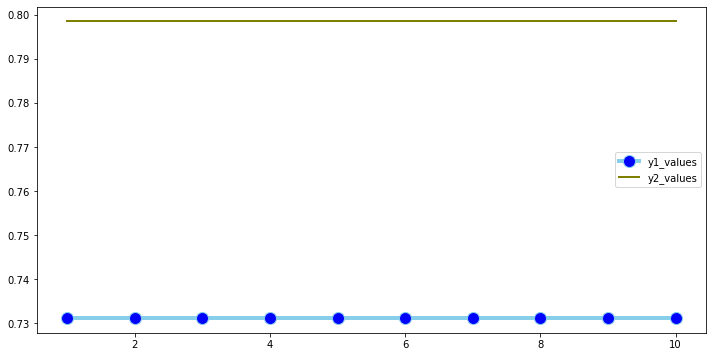

In [100]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Data
df=pd.DataFrame({'x_values': range(1,11), 'y1_values': test_score_l, 'y2_values': train_score_l })
 
# multiple line plots
plt.plot( 'x_values', 'y1_values', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'x_values', 'y2_values', data=df, marker='', color='olive', linewidth=2)

# show legend
plt.legend()

# show graph
plt.show()

ValueError: Illegal format string "y1_values"; two marker symbols

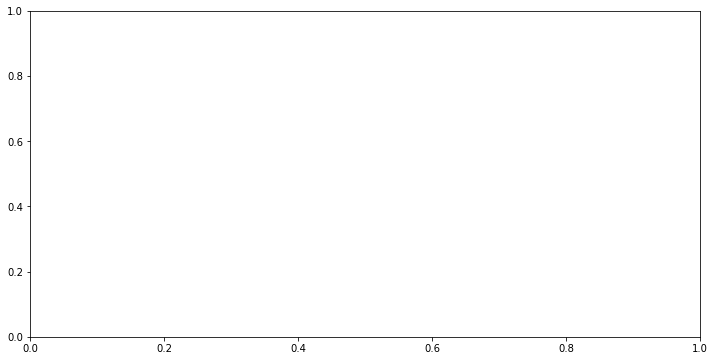

In [94]:
# multiple line plots
# multiple line plots
plt.plot( 'x_values', 'y1_values', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'x_values', 'y2_values', data=df, marker='', color='olive', linewidth=2)

# show legend
plt.legend()

# show graph
plt.show()